# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"

%cd /content/gdrive/My Drive/Colab Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [2]:
#Import all the required libraries
import random
import numpy as np
import pandas as pd
import glob
import pathlib, os
from collections import Counter , OrderedDict
import string
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
import PIL
import PIL.Image
import time

# image processing
from skimage import io
from skimage.transform import rescale, resize

# import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# sklearn
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# #Import the dataset and read the image into a seperate variable
# checkpoint_path = "./checkpoints/train/*.*"

# chkpit = glob.glob(checkpoint_path,recursive=True)
# chkpit_co = len(chkpit)
# print("The total images present in the dataset: {}".format(chkpit_co))
# for i in chkpit:
#   os.remove(i)

# chkpit = glob.glob(checkpoint_path,recursive=True)
# chkpit_co = len(chkpit)
# print("The total images present in the dataset: {}".format(chkpit_co))

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [4]:
#Import the dataset and read the image into a seperate variable
images='Flickr8K/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
image_count = len(all_imgs)
print(all_imgs[:3])
print("The total images present in the dataset: {}".format(image_count))

['Flickr8K/Images/407678652_1f475acd65.jpg', 'Flickr8K/Images/393810324_1c33760a95.jpg', 'Flickr8K/Images/421153376_d1d325568f.jpg']
The total images present in the dataset: 8091


In [5]:
 #Import the dataset and read the text file into a seperate variable
text_file = 'Flickr8K/captions.txt'
def load_doc(filename):
    #your code here
    text = open(filename, 'r', encoding = 'utf-8').read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


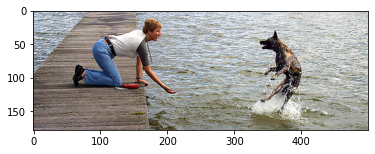

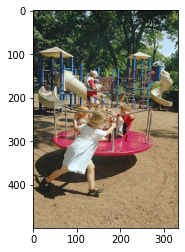

In [6]:
#Visualise a few images
for i in range(3, 7, 2):
    plt.figure()
    img = PIL.Image.open(all_imgs[i])
    plt.imshow(img)

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
# # utility function to clean the caption text
def clean_caption(caption):
    table = str.maketrans('','', string.punctuation)
    desc = caption.split() #create a list of words

    # remove the punctuation from each word
    desc = [word.translate(table) for word in desc]
    
    # remove empty strings and strings like 's and a
    desc = [word.strip() for word in desc if len(word.strip())>1]
    desc = [word.lower() for word in desc if(word.isalpha())] # convert to lower case and pick only alpha numeric 
    return ' '.join(desc)

# def clean_caption(text):
#     return ''.join(e for e in text if e.isalnum() or e == ' ')

In [8]:
# utility token to append <start> and <end>
def appendDelimitingTokes(caption):
    return f'<start> {caption} <end>'

In [9]:
# utility function to generate image path
def getImagePaths(s):
    return s.replace('\\', '/')

In [10]:
# get file name from the path
def getFileName(path):
    return path[len(images)+1:]

In [11]:
# utility function to generate mappings of captions to images as a dictionary with image path as index. 
def MapImageCaptions(doc):
    captionDict = dict()
    text_lines = doc.split('\n')
    # remove the header line
    text_lines.pop(0)
    text_lines = [t for t in text_lines if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split(',', 1)
        dict_index = images + '/' + dict_index
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(appendDelimitingTokes(clean_caption(dict_val)))
    return captionDict

In [12]:
captionMappings = MapImageCaptions(doc)
len(captionMappings.items())

8091

In [13]:
all_img_vector= list(captionMappings.keys()) #store all the image path here
all_img_id= list(map(getFileName, all_img_vector))#store all the image id here


In [14]:
annotations= captionMappings.values() #store all the captions here

In [15]:
# create a data frame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df.head(5)

(8091, 3)


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,[<start> child in pink dress is climbing up se...
1,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,[<start> black dog and spotted dog are fightin...
2,1002674143_1b742ab4b8.jpg,Flickr8K/Images/1002674143_1b742ab4b8.jpg,[<start> little girl covered in paint sits in ...
3,1003163366_44323f5815.jpg,Flickr8K/Images/1003163366_44323f5815.jpg,[<start> man lays on bench while his dog sits ...
4,1007129816_e794419615.jpg,Flickr8K/Images/1007129816_e794419615.jpg,[<start> man in an orange hat starring at some...


In [16]:
## expand the data frame by creating 1 row for each caption
df = (df
 .set_index(['ID','Path'])['Captions']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Captions'}))
df.head(5)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playh...
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing the stairs to her...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl in pink dress going into w...


In [17]:
# plot the image along with it's captions. 
def image_desc_plotter(start=10, end=13, image_set=all_img_vector):
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for image in image_set[start:end]:
        image_id = getFileName(image)
        captions = list(df["Captions"].loc[df["ID"]==image_id].values)
        image_load = load_img(image, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

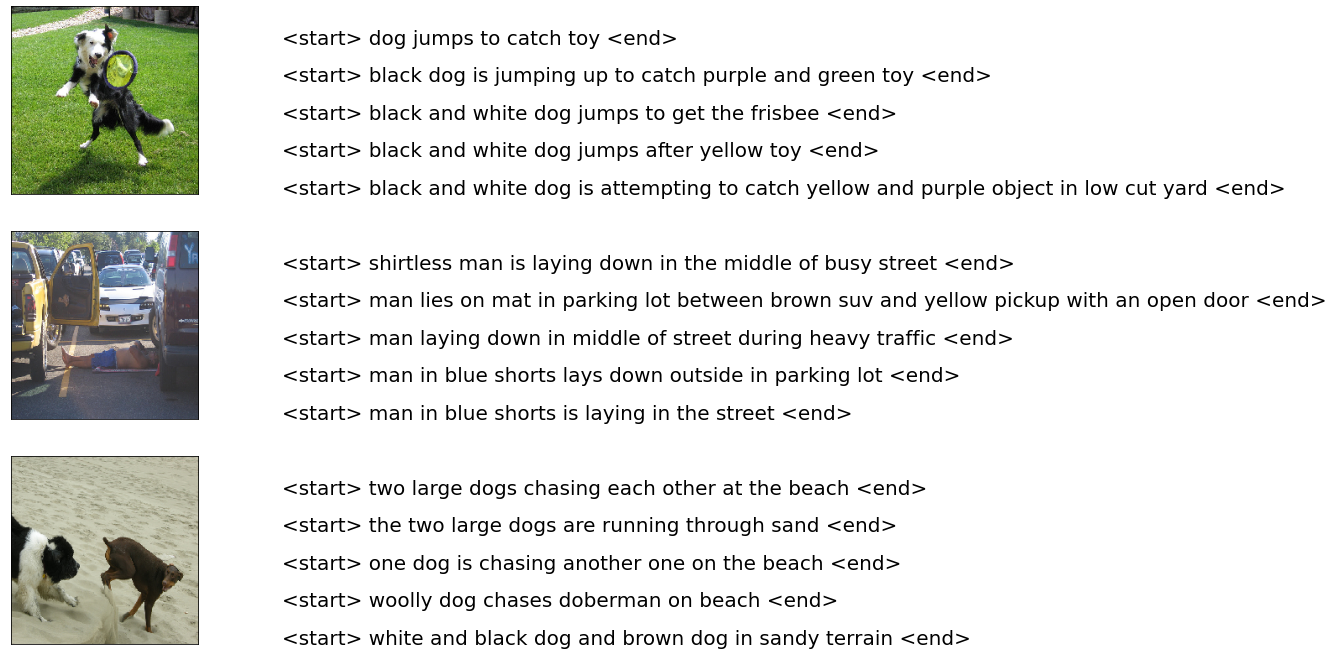

In [18]:
image_desc_plotter(50, 53)

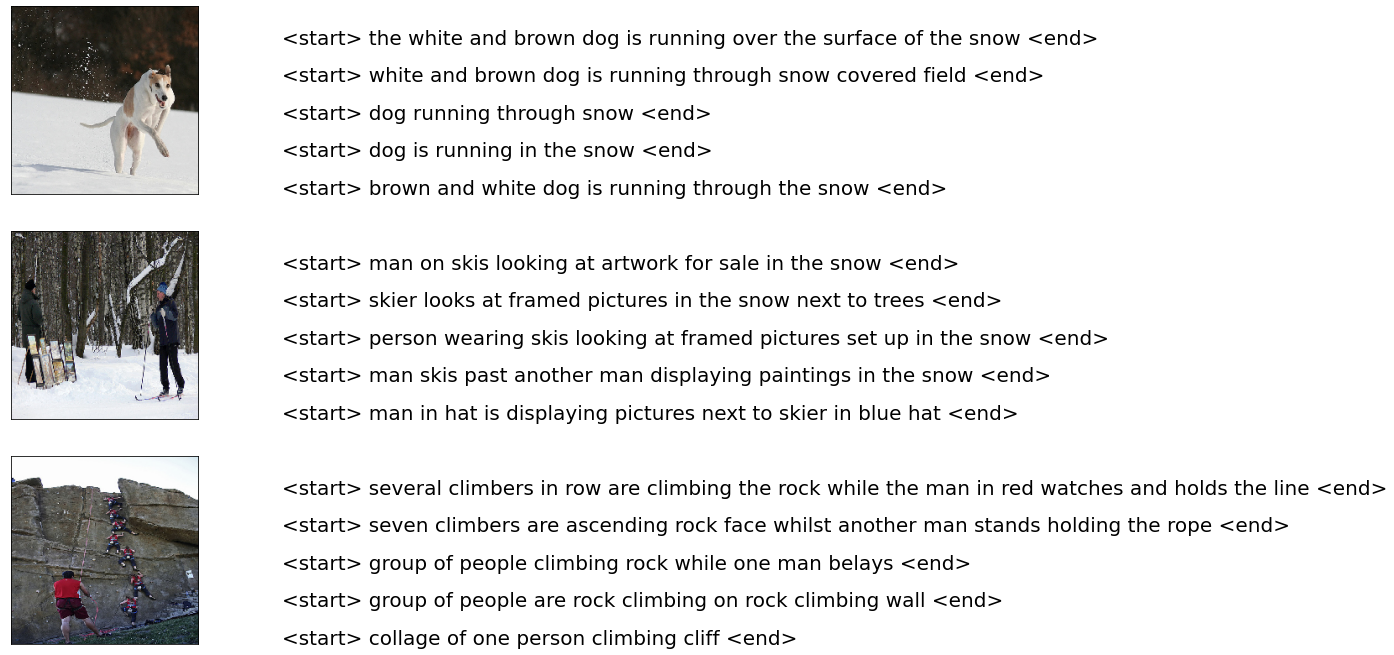

In [19]:
image_desc_plotter()

In [20]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
delimitedAnnotations = df['Captions'].values #GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total images present in the dataset: " + str(len(all_img_path)))
print("First delimited annotation " + delimitedAnnotations[0])

Total images present in the dataset: 8091
First delimited annotation <start> child in pink dress is climbing up set of stairs in an entry way <end>


In [21]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in delimitedAnnotations for word in line.split()] #write your code here
# val_count
val_count=Counter(vocabulary)


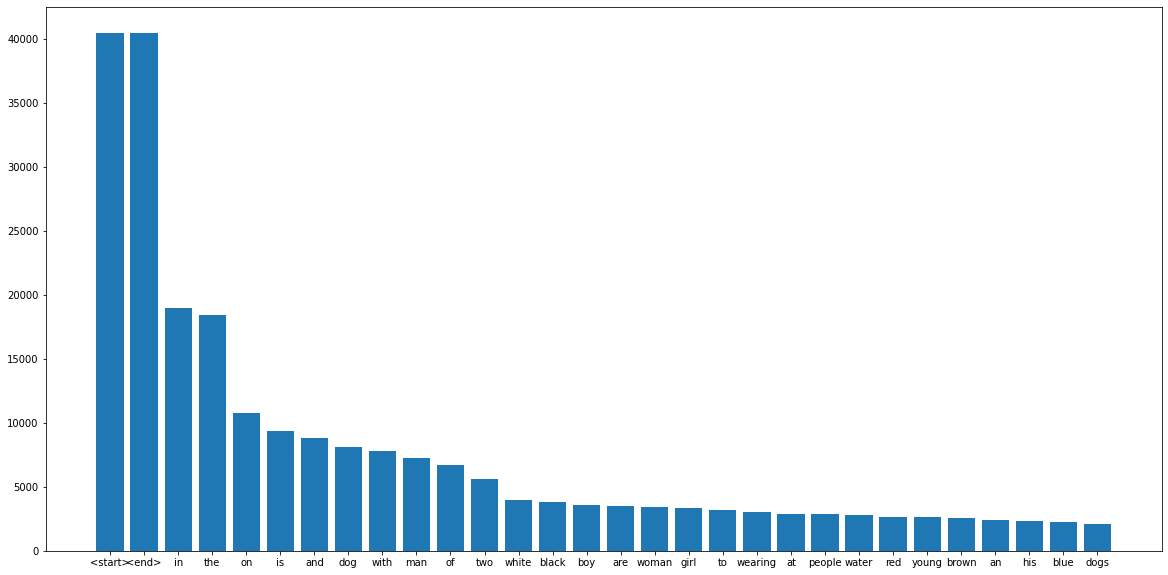

In [22]:
#Visualise the top 30 occuring words in the captions
#write your code here
plt.figure(figsize=(20, 10))
top_words = OrderedDict(val_count.most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [23]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
delimitedAnnotations = df['Captions'].values #GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total images present in the dataset: " + str(len(all_img_path)))
print("First delimited annotation " + delimitedAnnotations[0])

Total images present in the dataset: 8091
First delimited annotation <start> child in pink dress is climbing up set of stairs in an entry way <end>


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [24]:
# create the tokenizer
tokenizer = Tokenizer(num_words = 5001 , oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(delimitedAnnotations)

In [25]:
# Create word-to-index and index-to-word mappings.
# word to index mapping
wordIndex = tokenizer.word_index

In [26]:
#index-to-word mappings
indexToWord = tokenizer.index_word

In [27]:
# add the token for padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

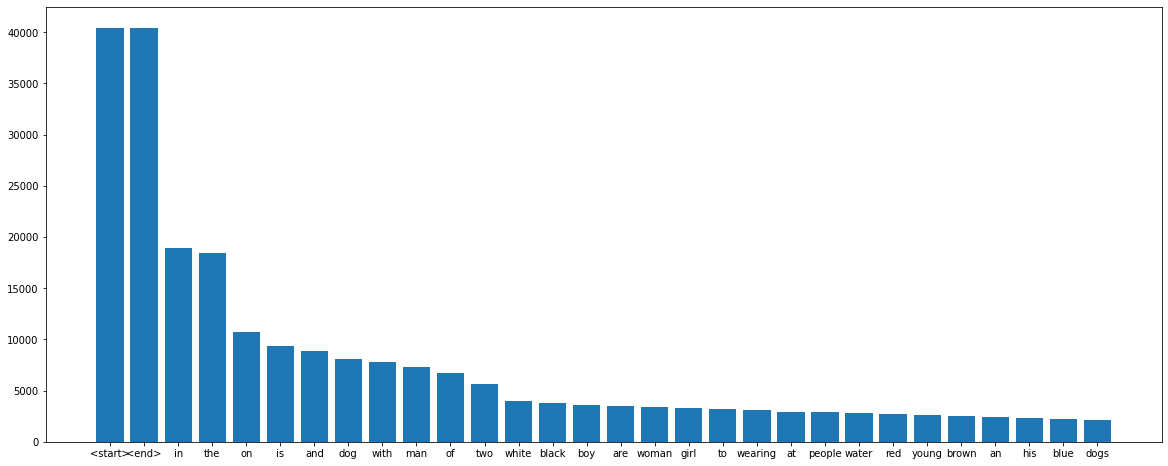

In [28]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
wordCounts = tokenizer.word_counts
plt.figure(figsize=(20, 8))
top_words = OrderedDict(Counter(wordCounts).most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [29]:
# tokenize the captions 
text_sequences = tokenizer.texts_to_sequences(delimitedAnnotations)

In [30]:
# max length of the tokenized caption
MaxLength = max(len(d) for d in text_sequences)
MaxLength

34

In [31]:
# min length of tokenized captions
MinLength = min(len(d) for d in text_sequences)
MinLength

2

In [32]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= pad_sequences(text_sequences, padding='post') #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


In [33]:
# view the caption vector

In [34]:
# min length is now equal to max length
MinLength = min(len(d) for d in cap_vector)
MinLength

34

In [35]:
# tokenize all the captions. 
df['tokenizedCaptions']  = list(pad_sequences(tokenizer.texts_to_sequences(df['Captions']), padding='post'))
df.head(10)

,ID,Path,Captions,tokenizedCaptions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> child in pink dress is climbing up set...,"[2, 42, 4, 90, 169, 7, 119, 53, 394, 12, 391, ..."
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> girl going into wooden building <end>,"[2, 19, 313, 64, 193, 117, 3, 0, 0, 0, 0, 0, 0..."
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing into wooden playh...,"[2, 40, 19, 119, 64, 193, 2423, 3, 0, 0, 0, 0,..."
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl climbing the stairs to her...,"[2, 40, 19, 119, 5, 391, 20, 60, 2423, 3, 0, 0..."
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> little girl in pink dress going into w...,"[2, 40, 19, 4, 90, 169, 313, 64, 193, 2985, 3,..."
5,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and spotted dog are fighting...,"[2, 15, 9, 8, 851, 9, 17, 342, 3, 0, 0, 0, 0, ..."
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and tricolored dog playing w...,"[2, 15, 9, 8, 1555, 9, 34, 10, 137, 82, 6, 5, ..."
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> black dog and white dog with brown spo...,"[2, 15, 9, 8, 14, 9, 10, 27, 996, 17, 636, 22,..."
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> two dogs of different breeds looking a...,"[2, 13, 31, 12, 737, 2641, 88, 22, 137, 82, 6,..."
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> two dogs on pavement moving toward eac...,"[2, 13, 31, 6, 719, 795, 318, 137, 82, 3, 0, 0..."


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [36]:
#write your code here
# define the image size
rows = 299
cols = 299

# utility function to read image from given path and process it for inception model
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, file_path

# return image and corresponding caption as passed
def load_image(file_path, cap=None):
    img , _ = process_path(file_path)
    return img, cap

# function to load feature vector saved using imagenet earlier and map it to caption
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [37]:
batch_size=64
BUFFER_SIZE = 500

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [38]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =  tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [39]:
# write your code to extract features from each image in the dataset
image_vector = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(image_vector)
image_dataset = image_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)


In [40]:
# for img, path in image_dataset:
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     # we save the features to disk. 
#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [41]:
# get data from dataframe based on keys
def getKeyValueLists(keys):
    data = df.loc[df['ID'].isin(keys)]
    return data['Path'].tolist(), data['tokenizedCaptions'].tolist()

In [42]:
# train test split
train_images, val_images = train_test_split(all_img_id, train_size=0.8, random_state = 42)
len(train_images),len(val_images)

(6472, 1619)

In [43]:
# caption and image path arrays for training data
train_image_idx, train_captions = getKeyValueLists(train_images)
print(len(train_image_idx), len(train_captions))

32360 32360


In [44]:
# caption and image path arrays for validation data
val_image_idx, val_captions = getKeyValueLists(val_images)
print(len(val_image_idx), len(val_captions))

8095 8095


In [45]:
# create train dataset using data api
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [46]:
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [47]:
# view the final data set
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 34)


## Test data

In [48]:
# create test dataset using the data api
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          load_image, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
# shuffle and batch the data
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

In [49]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch_test.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64, 34)


## Train data from feature vector

In [50]:
#  create a tensor from given data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [51]:
# Use map to load the numpy files in parallel. The final dataset will be in  (feature, tokenizedCaption) form
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [52]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [53]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Test data

In [54]:
#  create a tensor from given data
test_dataset = tf.data.Dataset.from_tensor_slices((val_image_idx, val_captions))

In [55]:
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [56]:
# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(batch_size,drop_remainder=True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [57]:
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch_test.shape) #(batch_size,40)

(64, 64, 2048)
(64, 34)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [58]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image_idx) // batch_size
test_num_steps = len(val_image_idx) // batch_size

### Encoder

In [59]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [60]:
encoder=Encoder(embedding_dim)

### Attention model

In [61]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [62]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    # reset_state
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [63]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [64]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)
dec_input = tf.cast(dec_input, dtype=tf.float32)

In [65]:
predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [66]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [67]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [68]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [69]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [70]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        feature = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, feature, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [71]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
    # passing the features through the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
      
        predicted_id = tf.argmax(predictions[0])
        # dec_input = tf.expand_dims([predicted_id]*batch_size, 1)
 
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [72]:
def test_loss_cal(test_dataset):
    total_loss = 0
    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # print('test_batch', batch)
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [73]:
EPOCHS = 25
loss_plot = []
test_loss_plot = []
best_test_loss=100

In [74]:
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    avg_train_loss = total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
        
    print ('Epoch {} training Loss {:.6f}, test loss : {:.6f}'.format(epoch + 1,total_loss/train_num_steps, best_test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # ckpt_manager.save()

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 2.5442
Epoch 1 Batch 100 Loss 1.4729
Epoch 1 Batch 200 Loss 1.4657
Epoch 1 Batch 300 Loss 1.3782
Epoch 1 Batch 400 Loss 1.1371
Epoch 1 Batch 500 Loss 1.1365
Test loss has been reduced from 100.000 to 2.513


  4%|▍         | 1/25 [02:47<1:06:54, 167.25s/it]

Epoch 1 training Loss 1.379303, test loss : 2.512567
Time taken for 1 epoch 167.25301480293274 sec

Epoch 2 Batch 0 Loss 1.2327
Epoch 2 Batch 100 Loss 1.0541
Epoch 2 Batch 200 Loss 1.0802
Epoch 2 Batch 300 Loss 1.1273
Epoch 2 Batch 400 Loss 1.0753
Epoch 2 Batch 500 Loss 1.0529


  8%|▊         | 2/25 [04:51<59:11, 154.42s/it]  

Epoch 2 training Loss 1.090426, test loss : 2.512567
Time taken for 1 epoch 124.47613763809204 sec

Epoch 3 Batch 0 Loss 1.0442
Epoch 3 Batch 100 Loss 0.9536
Epoch 3 Batch 200 Loss 1.0442
Epoch 3 Batch 300 Loss 1.0464
Epoch 3 Batch 400 Loss 0.9778
Epoch 3 Batch 500 Loss 0.9712


 12%|█▏        | 3/25 [06:53<52:59, 144.54s/it]

Epoch 3 training Loss 0.993495, test loss : 2.512567
Time taken for 1 epoch 121.47085285186768 sec

Epoch 4 Batch 0 Loss 0.9344
Epoch 4 Batch 100 Loss 0.9688
Epoch 4 Batch 200 Loss 0.9517
Epoch 4 Batch 300 Loss 0.9126
Epoch 4 Batch 400 Loss 0.9450
Epoch 4 Batch 500 Loss 0.8246


 16%|█▌        | 4/25 [08:54<48:09, 137.57s/it]

Epoch 4 training Loss 0.926176, test loss : 2.512567
Time taken for 1 epoch 121.32520580291748 sec

Epoch 5 Batch 0 Loss 0.9279
Epoch 5 Batch 100 Loss 0.8591
Epoch 5 Batch 200 Loss 0.7887
Epoch 5 Batch 300 Loss 0.8318
Epoch 5 Batch 400 Loss 0.9147
Epoch 5 Batch 500 Loss 0.8035


 20%|██        | 5/25 [10:55<44:14, 132.70s/it]

Epoch 5 training Loss 0.870283, test loss : 2.512567
Time taken for 1 epoch 121.33775877952576 sec

Epoch 6 Batch 0 Loss 0.8912
Epoch 6 Batch 100 Loss 0.7421
Epoch 6 Batch 200 Loss 0.6380
Epoch 6 Batch 300 Loss 0.8846
Epoch 6 Batch 400 Loss 0.7981
Epoch 6 Batch 500 Loss 0.8257


 24%|██▍       | 6/25 [12:57<40:56, 129.28s/it]

Epoch 6 training Loss 0.820009, test loss : 2.512567
Time taken for 1 epoch 121.28886127471924 sec

Epoch 7 Batch 0 Loss 0.7433
Epoch 7 Batch 100 Loss 0.7304
Epoch 7 Batch 200 Loss 0.7565
Epoch 7 Batch 300 Loss 0.8192
Epoch 7 Batch 400 Loss 0.8441
Epoch 7 Batch 500 Loss 0.7632


 28%|██▊       | 7/25 [14:58<38:03, 126.84s/it]

Epoch 7 training Loss 0.780271, test loss : 2.512567
Time taken for 1 epoch 121.15877842903137 sec

Epoch 8 Batch 0 Loss 0.7204
Epoch 8 Batch 100 Loss 0.6399
Epoch 8 Batch 200 Loss 0.6434
Epoch 8 Batch 300 Loss 0.7671
Epoch 8 Batch 400 Loss 0.7602
Epoch 8 Batch 500 Loss 0.6748


 32%|███▏      | 8/25 [16:59<35:29, 125.28s/it]

Epoch 8 training Loss 0.736734, test loss : 2.512567
Time taken for 1 epoch 121.61581134796143 sec

Epoch 9 Batch 0 Loss 0.7639
Epoch 9 Batch 100 Loss 0.7116
Epoch 9 Batch 200 Loss 0.7096
Epoch 9 Batch 300 Loss 0.7150
Epoch 9 Batch 400 Loss 0.6849
Epoch 9 Batch 500 Loss 0.7018


 36%|███▌      | 9/25 [19:01<33:05, 124.07s/it]

Epoch 9 training Loss 0.695952, test loss : 2.512567
Time taken for 1 epoch 121.264080286026 sec

Epoch 10 Batch 0 Loss 0.6792
Epoch 10 Batch 100 Loss 0.6933
Epoch 10 Batch 200 Loss 0.6490
Epoch 10 Batch 300 Loss 0.7035
Epoch 10 Batch 400 Loss 0.6621
Epoch 10 Batch 500 Loss 0.6353


 40%|████      | 10/25 [21:02<30:48, 123.22s/it]

Epoch 10 training Loss 0.659465, test loss : 2.512567
Time taken for 1 epoch 121.23814630508423 sec

Epoch 11 Batch 0 Loss 0.7114
Epoch 11 Batch 100 Loss 0.5722
Epoch 11 Batch 200 Loss 0.6431
Epoch 11 Batch 300 Loss 0.6386
Epoch 11 Batch 400 Loss 0.6516
Epoch 11 Batch 500 Loss 0.5994


 44%|████▍     | 11/25 [23:03<28:37, 122.66s/it]

Epoch 11 training Loss 0.625811, test loss : 2.512567
Time taken for 1 epoch 121.35979890823364 sec

Epoch 12 Batch 0 Loss 0.5901
Epoch 12 Batch 100 Loss 0.6202
Epoch 12 Batch 200 Loss 0.5746
Epoch 12 Batch 300 Loss 0.5875
Epoch 12 Batch 400 Loss 0.5611
Epoch 12 Batch 500 Loss 0.5686


 48%|████▊     | 12/25 [25:05<26:30, 122.34s/it]

Epoch 12 training Loss 0.594698, test loss : 2.512567
Time taken for 1 epoch 121.56932520866394 sec

Epoch 13 Batch 0 Loss 0.5328
Epoch 13 Batch 100 Loss 0.6412
Epoch 13 Batch 200 Loss 0.5647
Epoch 13 Batch 300 Loss 0.5418
Epoch 13 Batch 400 Loss 0.6559
Epoch 13 Batch 500 Loss 0.5873


 52%|█████▏    | 13/25 [27:07<24:25, 122.16s/it]

Epoch 13 training Loss 0.565930, test loss : 2.512567
Time taken for 1 epoch 121.74076247215271 sec

Epoch 14 Batch 0 Loss 0.5890
Epoch 14 Batch 100 Loss 0.5672
Epoch 14 Batch 200 Loss 0.5133
Epoch 14 Batch 300 Loss 0.4787
Epoch 14 Batch 400 Loss 0.5456
Epoch 14 Batch 500 Loss 0.5557


 56%|█████▌    | 14/25 [29:09<22:24, 122.24s/it]

Epoch 14 training Loss 0.539473, test loss : 2.512567
Time taken for 1 epoch 122.43414855003357 sec

Epoch 15 Batch 0 Loss 0.5424
Epoch 15 Batch 100 Loss 0.4755
Epoch 15 Batch 200 Loss 0.4919
Epoch 15 Batch 300 Loss 0.6064
Epoch 15 Batch 400 Loss 0.5326
Epoch 15 Batch 500 Loss 0.4638


 60%|██████    | 15/25 [31:11<20:20, 122.01s/it]

Epoch 15 training Loss 0.514660, test loss : 2.512567
Time taken for 1 epoch 121.47496199607849 sec

Epoch 16 Batch 0 Loss 0.5107
Epoch 16 Batch 100 Loss 0.4738
Epoch 16 Batch 200 Loss 0.4483
Epoch 16 Batch 300 Loss 0.4709
Epoch 16 Batch 400 Loss 0.4892
Epoch 16 Batch 500 Loss 0.4708


 64%|██████▍   | 16/25 [33:12<18:17, 121.99s/it]

Epoch 16 training Loss 0.492231, test loss : 2.512567
Time taken for 1 epoch 121.92282819747925 sec

Epoch 17 Batch 0 Loss 0.5221
Epoch 17 Batch 100 Loss 0.4445
Epoch 17 Batch 200 Loss 0.5062
Epoch 17 Batch 300 Loss 0.4052
Epoch 17 Batch 400 Loss 0.5011
Epoch 17 Batch 500 Loss 0.4740


 68%|██████▊   | 17/25 [35:14<16:14, 121.86s/it]

Epoch 17 training Loss 0.471115, test loss : 2.512567
Time taken for 1 epoch 121.58200669288635 sec

Epoch 18 Batch 0 Loss 0.4460
Epoch 18 Batch 100 Loss 0.4247
Epoch 18 Batch 200 Loss 0.4706
Epoch 18 Batch 300 Loss 0.4791
Epoch 18 Batch 400 Loss 0.4583
Epoch 18 Batch 500 Loss 0.4723


 72%|███████▏  | 18/25 [37:15<14:12, 121.72s/it]

Epoch 18 training Loss 0.450996, test loss : 2.512567
Time taken for 1 epoch 121.37218713760376 sec

Epoch 19 Batch 0 Loss 0.4412
Epoch 19 Batch 100 Loss 0.4473
Epoch 19 Batch 200 Loss 0.4240
Epoch 19 Batch 300 Loss 0.4795
Epoch 19 Batch 400 Loss 0.4446
Epoch 19 Batch 500 Loss 0.4508


 76%|███████▌  | 19/25 [39:17<12:09, 121.54s/it]

Epoch 19 training Loss 0.433197, test loss : 2.512567
Time taken for 1 epoch 121.13397073745728 sec

Epoch 20 Batch 0 Loss 0.3864
Epoch 20 Batch 100 Loss 0.3816
Epoch 20 Batch 200 Loss 0.3607
Epoch 20 Batch 300 Loss 0.3629
Epoch 20 Batch 400 Loss 0.4327
Epoch 20 Batch 500 Loss 0.4127


 80%|████████  | 20/25 [41:18<10:06, 121.39s/it]

Epoch 20 training Loss 0.416345, test loss : 2.512567
Time taken for 1 epoch 121.039297580719 sec

Epoch 21 Batch 0 Loss 0.4219
Epoch 21 Batch 100 Loss 0.3951
Epoch 21 Batch 200 Loss 0.4174
Epoch 21 Batch 300 Loss 0.4145
Epoch 21 Batch 400 Loss 0.4181
Epoch 21 Batch 500 Loss 0.4274


 84%|████████▍ | 21/25 [43:18<08:04, 121.19s/it]

Epoch 21 training Loss 0.403294, test loss : 2.512567
Time taken for 1 epoch 120.72382950782776 sec

Epoch 22 Batch 0 Loss 0.3740
Epoch 22 Batch 100 Loss 0.3892
Epoch 22 Batch 200 Loss 0.4347
Epoch 22 Batch 300 Loss 0.3345
Epoch 22 Batch 400 Loss 0.4427
Epoch 22 Batch 500 Loss 0.3683


 88%|████████▊ | 22/25 [45:20<06:03, 121.20s/it]

Epoch 22 training Loss 0.388774, test loss : 2.512567
Time taken for 1 epoch 121.22781109809875 sec

Epoch 23 Batch 0 Loss 0.3644
Epoch 23 Batch 100 Loss 0.3951
Epoch 23 Batch 200 Loss 0.3721
Epoch 23 Batch 300 Loss 0.3647
Epoch 23 Batch 400 Loss 0.3916
Epoch 23 Batch 500 Loss 0.3893


 92%|█████████▏| 23/25 [47:20<04:02, 121.13s/it]

Epoch 23 training Loss 0.373876, test loss : 2.512567
Time taken for 1 epoch 120.95607042312622 sec

Epoch 24 Batch 0 Loss 0.3971
Epoch 24 Batch 100 Loss 0.3638
Epoch 24 Batch 200 Loss 0.4193
Epoch 24 Batch 300 Loss 0.3246
Epoch 24 Batch 400 Loss 0.3831
Epoch 24 Batch 500 Loss 0.3356


 96%|█████████▌| 24/25 [49:21<02:01, 121.09s/it]

Epoch 24 training Loss 0.362378, test loss : 2.512567
Time taken for 1 epoch 120.99563837051392 sec

Epoch 25 Batch 0 Loss 0.3543
Epoch 25 Batch 100 Loss 0.3649
Epoch 25 Batch 200 Loss 0.3288
Epoch 25 Batch 300 Loss 0.3436
Epoch 25 Batch 400 Loss 0.3347
Epoch 25 Batch 500 Loss 0.3639


100%|██████████| 25/25 [51:22<00:00, 123.31s/it]

Epoch 25 training Loss 0.352070, test loss : 2.512567
Time taken for 1 epoch 120.81925225257874 sec



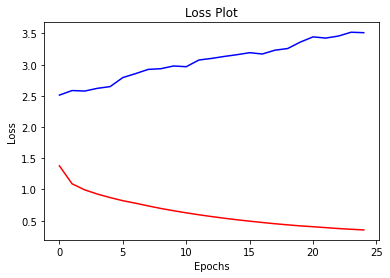

In [75]:
plt.plot(loss_plot, color = 'red')
plt.plot(test_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [76]:
attention_features_shape = 64 #assign from relevant variable above
def evaluate(image):
    attention_plot = np.zeros((MaxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MaxLength):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [77]:
# def plot_attmap(caption, weights, image):
#   # caption = result, weights = attentionplot, image= image
#     fig = plt.figure(figsize=(10, 10))
#     temp_img = np.array(PIL.Image.open(image))
    
#     len_cap = len(caption)
#     for cap in range(len_cap):
#         weights_img = np.reshape(weights[cap], (8,8))
#         # weights_img = np.array(PIL.Image.fromarray(weights_img).resize((224, 224), PIL.Image.LANCZOS))
        
#         ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
#         ax.set_title(caption[cap], fontsize=15)
        
#         img=ax.imshow(temp_img)
        
#         ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
#         ax.axis('off')
#     plt.subplotsa_adjust(hspace=0.2, wspace=0.2)
#     # plt.tight_layout()
#     plt.show()

In [78]:

def plot_attmap(result,  attention_plot , image):
    temp_image = np.array(PIL.Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [79]:
from nltk.translate.bleu_score import sentence_bleu

In [80]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [81]:
rid = np.random.randint(0, len(val_image_idx))
#test_image = './images/413231421_43833a11f5.jpg'
test_image = val_image_idx[rid]

#real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
real_caption=filt_text(real_caption)      

print(rid, test_image, real_caption)

6079 Flickr8K/Images/3521201948_9049197f20.jpg muzzled greyhound dogs running in pack


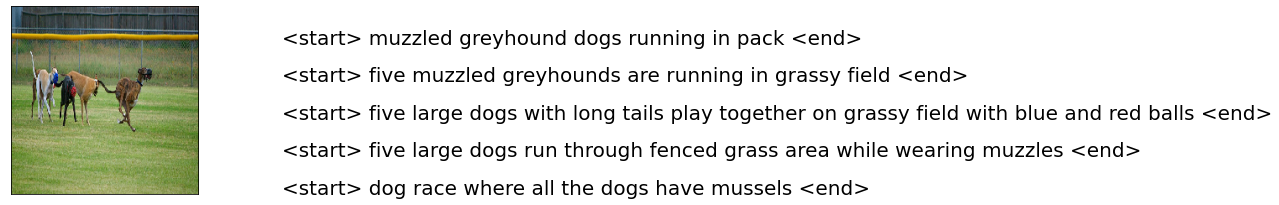

In [82]:
# view the test image and it's captions
image_desc_plotter(rid, rid+1, val_image_idx)

BELU score: 27.735009811261456
Real Caption: muzzled greyhound dogs running in pack
Prediction Caption: dog runs around the grass with jumping in field of field of grass


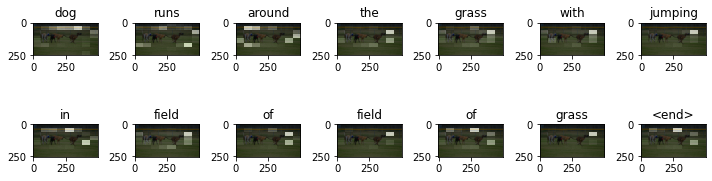

In [83]:
# predict using greedy search
result, attention_plot,pred_test = evaluate(test_image)
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

# calculate bleu score 
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

In [84]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((MaxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < MaxLength:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption



In [85]:
# evaluate using beam search
captions=beam_evaluate(test_image, 7)
print(captions)
candidate = captions.split()
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")
print ('Real Caption:', real_caption)


dog chasing ball
BELU score: 0
Real Caption: muzzled greyhound dogs running in pack
